# CHANNEL SELECTION

In [4]:
from collections import Counter
import pandas as pd
import os

path = "/kaggle/input/raw-eeg-2b"
y_batch = pd.read_csv(os.path.join(path, "y_raw_train2B.csv"), header=0)

labels = y_batch.to_numpy().flatten()
print(Counter(labels))

Counter({1: 3423, 7: 3107, 3: 3073, 9: 3003, 6: 2975, 0: 2961, 2: 2948, 4: 2926, 8: 2875, 5: 2709})


## Domain Knowledge

In [1]:
# COMPLETE
channels_128 = [
    # Frontal
    'FP1', 'FPz', 'FP2',
    'AFp1', 'AFPz', 'AFp2',
    'AF7', 'AF3', 'AF4', 'AF8',
    'AFF5h', 'AFF1h', 'AFF2h', 'AFF6h',
    'F9', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'F10',

    # Fronto-Temporal
    'FFT9h', 'FFT7h',
    'FFC5h', 'FFC3h', 'FFC1h', 'FFC2h', 'FFC4h', 'FFC6h',
    'FFT8h', 'FFT10h',
    'FT9', 'FT7', 'FT8', 'FT10',

    # Fronto-Central
    'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6',
    'FTT9h', 'FTT7h',
    'FCC5h', 'FCC3h', 'FCC1h', 'FCC2h', 'FCC4h', 'FCC6h',
    'FTT8h', 'FTT10h',

    # Central & Temporal
    'T7', 'T8',
    'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6',

    # Centro-Parietal
    'TTP7h', 'CCP5h', 'CCP3h', 'CCP1h', 'CCP2h', 'CCP4h', 'CCP6h', 'TTP8h',
    'CP5', 'CP3', 'Cpz', 'CP4', 'CP6',

    # Parietal
    'TP9', 'TP7', 'TP8', 'TP10',
    'TPP9h', 'TPP7h', 'CPP5h', 'CPP3h', 'CPP1h', 'CPP2h', 'CPP4h', 'CPP6h', 'TPP8h', 'TPP10h',
    'P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10',

    # Parieto-Occipital
    'PPO9h', 'PPO5h', 'PPO1h', 'PPO2h', 'PPO6h', 'PPO10h',
    'PO9', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'PO10',
    'POO9h', 'POO1', 'POO2', 'POO10h',

    # Occipital & Inferior
    'O1', 'Oz', 'O2',
    'OI1h', 'OI2h',
    'I1', 'Iz', 'I2'
]

In [ ]:
# Used in BRAINS
channels_32 = ["FP1", "AF3", "F3", "FC1", "C3", "FC3", "T7", "CP5",
               "CPP1h", "P1", "P7", "P9", "PO3", "O1", "OI1h", "POz", 
               "Oz", "OI2h", "O2", "PO4", "P10", "P8", "P2", "CPP2h",
               "CP6", "T8", "FC4", "C4", "FC2", "F4", "AF4", "FP2"]

In [ ]:
# Highest Attribution Score according to BRAINS
channels_of_interest = ['AF4', 'POz', 'PO3', 'F4', 'FC4']

In [ ]:
# (Khalegi dkk. with Emotiv EPOC Dataset)
selected_channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1',  # Left Hemisphere
                     'AF4', 'F8', 'F4', 'FC6', 'T8', 'P8', 'O2']  # Right Hemisphere

In [ ]:
# Occipital and Frontal
OF_channels = ['O1', 'Oz', 'O2', 'FP1', 'FPz', 'FP2', 'AFp1', 
               'AFPz', 'AFp2', 'AF7', 'AF3', 'AF4', 'AF8', 'AFF5h', 
               'AFF1h', 'AFF2h', 'AFF6h', 'F9', 'F7', 'F5', 'F3', 
               'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'F10',]

## Data-Driven

### Extract Data

In [2]:
# RAW (FROM HUGGING FACE)
from datasets import load_dataset
from itertools import islice
import pandas as pd
import numpy as np
from keras.utils import to_categorical

dataset = load_dataset("DavidVivancos/MindBigData2023_MNIST-2B", split="train", streaming=True)
batch_iterator = iter(dataset)

X_batch = []
y_batch = []

n_channels = 128
n_timesteps = 256

batch_size = 3000
for i in range(20):
    print(f"Retrieving batch {i}...", flush=True)
    batch = list(islice(batch_iterator, batch_size))
    batch = pd.DataFrame(batch)

    # Remove Data with Label -1
    data = batch[batch['label'] != -1]

    # Take Selected Channels and Timesteps' Columns
    selected_columns = [col for col in data.columns
                        if any(col.startswith(ch + '_') \
                               and 0 <= int(col.split('_')[-1]) <= 255
                               for ch in channels_128)
                        or col == 'label']
    data = data[selected_columns]

    # INTEGRATION AND RESHAPE
    data_array = data.iloc[:, :-1].values \
                                  .reshape((-1, n_channels, n_timesteps)) \
                                  .astype(np.float32)
    labels = data['label'].values

    X_batch.append(data_array)
    y_batch.append(to_categorical(labels, num_classes=10).astype('float32'))\

X = np.concatenate(X_batch, axis=0)
y = np.concatenate(y_batch, axis=0)

2025-07-06 09:08:33.377542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751792913.608771      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751792913.674764      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


README.md: 0.00B [00:00, ?B/s]

Retrieving batch 0...
Retrieving batch 1...
Retrieving batch 2...
Retrieving batch 3...
Retrieving batch 4...
Retrieving batch 5...
Retrieving batch 6...
Retrieving batch 7...
Retrieving batch 8...
Retrieving batch 9...
Retrieving batch 10...
Retrieving batch 11...
Retrieving batch 12...
Retrieving batch 13...
Retrieving batch 14...
Retrieving batch 15...
Retrieving batch 16...
Retrieving batch 17...
Retrieving batch 18...
Retrieving batch 19...


In [3]:
print(X.shape)
print(y.shape)

(30000, 128, 256)
(30000, 10)


In [4]:
X_tosave = X.reshape(X.shape[0], -1)
y_tosave = np.argmax(y, axis=1)

pd.DataFrame(X_tosave).to_csv("X_raw_train2B_128ch.csv", index=False)
pd.DataFrame(y_tosave, columns=["label"]).to_csv("y_raw_train2B_128ch.csv", index=False)

### Import Data

In [ ]:
# RAW 256 TS, 30 Ch 
import pandas as pd
import numpy as np
import os

path = "/kaggle/input/raw-eeg-2b"
X_batch = pd.read_csv(os.path.join(path, "X_raw_train2B.csv"), header=0)
y_batch = pd.read_csv(os.path.join(path, "y_raw_train2B.csv"), header=0)

X_batch = X_batch.to_numpy()
labels = y_batch.to_numpy().flatten()

n_channels = 32
n_timesteps = 256
X = X_batch.reshape(-1, n_channels, n_timesteps)

print(X.shape)
print(labels.shape)

### Statistical Feature Ranking (Univariate Feature Selection)

In [6]:
from sklearn.feature_selection import f_classif
scores, _ = f_classif(X.reshape(X.shape[0], X.shape[1]*X.shape[2]), y_tosave)

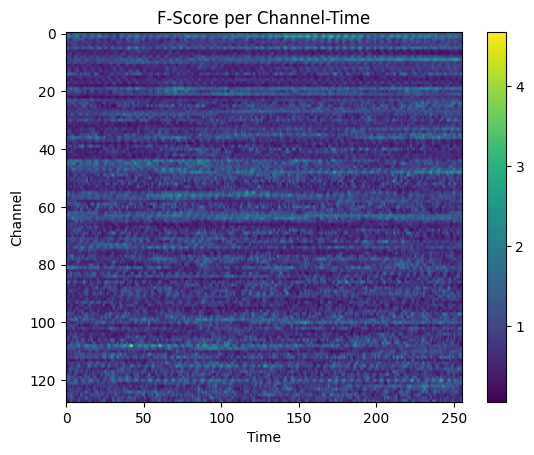

In [7]:
import matplotlib.pyplot as plt
scores_reshaped = scores.reshape(128, 256)

plt.imshow(scores_reshaped, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("F-Score per Channel-Time")
plt.xlabel("Time")
plt.ylabel("Channel")
plt.show()

In [10]:
channel_scores = scores.reshape(128, -1).mean(axis=1)
top_channels = np.argsort(channel_scores)[::-1]
print(top_channels)

[  1   9  19  63 108  48   5 120  56  64  44   0  36 100  99  81  21 115
  47  74 112  45  35  27  78  55 109  62  57  46   2  98  30 124  86  33
  84 106  14  72 125  20  10  25 111 122  60 114   8 102  28  69  49  90
  97 121 123  40  71  89  59 107  23 117 119 116  50   3  51  79  91  77
 127  24  26 118 126  88  73  58  65  68   4  93  83  52  12 105  80  34
  96  82  29  61  87  37  53 104  39 110  41  17  94  42  13  92  11  75
  85  70  32 103  31  16  54 101 113  43  95  76  67  38   7  15   6  66
  18  22]


In [12]:
for i in range(128):
    print(f"Rank {i}: {channels_128[top_channels[i]]}")

Rank 0: FPz
Rank 1: AF8
Rank 2: Fz
Rank 3: C4
Rank 4: PPO10h
Rank 5: FCC5h
Rank 6: AFp2
Rank 7: O1
Rank 8: T7
Rank 9: C6
Rank 10: FC4
Rank 11: FP1
Rank 12: FT7
Rank 13: P6
Rank 14: P4
Rank 15: TP10
Rank 16: F4
Rank 17: PO10
Rank 18: FTT7h
Rank 19: CP3
Rank 20: POz
Rank 21: FC6
Rank 22: FT9
Rank 23: FFC5h
Rank 24: TP9
Rank 25: FTT10h
Rank 26: PO9
Rank 27: C2
Rank 28: T8
Rank 29: FTT9h
Rank 30: FP2
Rank 31: P2
Rank 32: FFC2h
Rank 33: OI2h
Rank 34: CPP1h
Rank 35: FFT8h
Rank 36: CPP5h
Rank 37: PPO2h
Rank 38: F9
Rank 39: TTP8h
Rank 40: I1
Rank 41: F2
Rank 42: AFF5h
Rank 43: FFT9h
Rank 44: PO3
Rank 45: O2
Rank 46: C1
Rank 47: PO8
Rank 48: AF4
Rank 49: P10
Rank 50: FFC3h
Rank 51: CCP2h
Rank 52: FCC3h
Rank 53: TPP8h
Rank 54: Pz
Rank 55: Oz
Rank 56: OI1h
Rank 57: FC3
Rank 58: CCP6h
Rank 59: CPP6h
Rank 60: C3
Rank 61: PPO6h
Rank 62: F8
Rank 63: POO1
Rank 64: POO10h
Rank 65: POO9h
Rank 66: FCC1h
Rank 67: AFp1
Rank 68: FCC2h
Rank 69: TP7
Rank 70: TPP10h
Rank 71: CP6
Rank 72: I2
Rank 73: F10
Rank 7

### Recursive Feature Elimination (RFE) / Embedded Feature Selection

In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

X_mean_per_channel = X.mean(axis=2)
selector = SelectFromModel(RandomForestClassifier(random_state=42))
selector.fit(X_mean_per_channel, y_tosave)
important_channels = selector.get_support()

In [15]:
print(important_channels)

[ True False  True  True False False  True  True False  True  True  True
 False  True  True  True False  True False False False  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
 False  True False  True  True  True  True  True  True False  True  True
  True  True  True False False  True  True  True False False  True False
 False  True False  True  True False False  True False  True False  True
 False  True False  True  True  True  True  True  True  True  True False
  True  True False  True  True False False False  True False False  True
  True  True  True  True  True False  True  True False False  True False
 False  True  True  True  True  True  True  True  True False  True  True
 False False False  True  True False  True  True]


In [19]:
selected = [ch for ch, keep in zip(channels_128, important_channels) if keep]
print("Channels to be kept:", selected)
print("Number of channels to be kept:", len(selected))

Channels to be kept: ['FP1', 'FP2', 'AFp1', 'AF7', 'AF3', 'AF8', 'AFF5h', 'AFF1h', 'AFF6h', 'F9', 'F7', 'F3', 'F4', 'F6', 'F8', 'F10', 'FFT9h', 'FFC5h', 'FFC3h', 'FFC1h', 'FFC2h', 'FFC4h', 'FFC6h', 'FFT8h', 'FFT10h', 'FT9', 'FT8', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FTT9h', 'FTT7h', 'FCC5h', 'FCC3h', 'FCC1h', 'FCC6h', 'FTT8h', 'FTT10h', 'C5', 'Cz', 'C4', 'C6', 'CCP3h', 'CCP2h', 'CCP6h', 'CP5', 'Cpz', 'CP4', 'CP6', 'TP9', 'TP7', 'TP8', 'TP10', 'TPP9h', 'CPP5h', 'CPP3h', 'CPP2h', 'CPP4h', 'P9', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P10', 'PPO9h', 'PPO2h', 'PO9', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'PO10', 'POO9h', 'POO2', 'POO10h', 'OI1h', 'OI2h', 'Iz', 'I2']
Number of channels to be kept: 85


### Sequential Forward / Backward Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector

clf = RandomForestClassifier(random_state=42)

sfs = SequentialFeatureSelector(
    clf, 
    k_features=10, 
    forward=True, 
    scoring='accuracy',
    cv=5
)

X_channelwise = X.mean(axis=2)
sfs.fit(X_channelwise, y)

In [ ]:
select = [channels_128[idx] for idx in list(sfs.k_feature_idx_)]
print(select)
print(len(select))

### One-Channel Classification Ranking
#### Note: Preprocessed Data, 32 channels

### Correlation Analysis
#### Note: Preprocessed Data, 32 channels